<a href="https://colab.research.google.com/github/senorred/IDS-Data-Challenges/blob/master/Norred_Liz_HappyHotel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You've just joined the data team at a large hotelling chain. Your specific team is embedded in the CX (customer experience) division. Each day you receive hundreds of reviews of your 10 hotels from your customers. Each review consists of a free-form text review and a report of "happy" or "not happy". A product manager on your team wants to understand each hotel's performance at a more granular level; they want to build a product to identify topics within reviews. All of your reviews are unlabeled, and it's infeasible to label them by hand.
Design and execute a method to identify topics within the reviews. For each topic, find a robust means of assigning a score to each hotel in that topic. For each of the ten hotels, what recommendations would you make to their general managers?

Drawn heavily from: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

##Mount Drive and Import Libraries and Data

In [26]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
#nltk.download('stopwords')
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [27]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(2018)

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
happy=pd.read_csv('/gdrive/My Drive/Insight Data Science/Data Challenges/happy_hotel/hotel_happy_reviews.csv')
sad=pd.read_csv('/gdrive/My Drive/Insight Data Science/Data Challenges/happy_hotel/hotel_not_happy_reviews.csv')
alldf= happy.append(sad)

##EDA

In [13]:
happy.head()

,User_ID,Description,Is_Response,hotel_ID
0,id10329,Stayed here with husband and sons on the way t...,happy,8
1,id10331,We had - rooms. One was very nice and clearly ...,happy,3
2,id10333,My wife & I stayed in this glorious city a whi...,happy,3
3,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,7
4,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3


In [17]:
sad.head()

,User_ID,Description,Is_Response,hotel_ID
0,id10326,The room was kind of clean but had a VERY stro...,not happy,3
1,id10327,I stayed at the Crown Plaza April -- - April -...,not happy,9
2,id10328,I booked this hotel through Hotwire at the low...,not happy,3
3,id10330,My girlfriends and I stayed here to celebrate ...,not happy,3
4,id10332,My husband and I have stayed in this hotel a f...,not happy,7


In [15]:
happy.isna().sum()

User_ID        0
Description    0
Is_Response    0
hotel_ID       0
dtype: int64

In [16]:
sad.isna().sum()

User_ID        0
Description    0
Is_Response    0
hotel_ID       0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe16dd4de80>]],
      dtype=object)

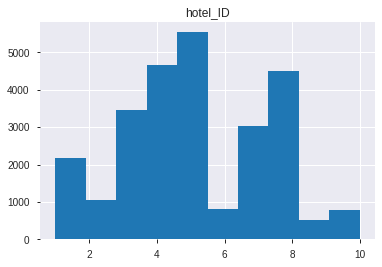

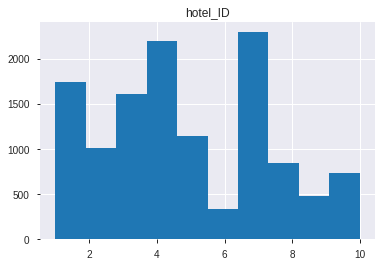

In [22]:
%matplotlib inline
happy.hist(bins=10)
sad.hist(bins=10)

In [26]:
happy.groupby(by='hotel_ID').count()

,User_ID,Description,Is_Response
hotel_ID,,,
1,2179,2179,2179
2,1046,1046,1046
3,3470,3470,3470
4,4651,4651,4651
5,5540,5540,5540
6,823,823,823
7,3019,3019,3019
8,4503,4503,4503
9,513,513,513


In [27]:
sad.groupby(by='hotel_ID').count()

,User_ID,Description,Is_Response
hotel_ID,,,
1,1750,1750,1750
2,1012,1012,1012
3,1612,1612,1612
4,2196,2196,2196
5,1142,1142,1142
6,334,334,334
7,2298,2298,2298
8,850,850,850
9,483,483,483


##Tokenize

In [0]:
def lemmatize_stemming(text):
    stemmer=SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [30]:
example=happy['Description'][0]

print('original document: ')
words = []
for word in example.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(example))

original document: 
['Stayed', 'here', 'with', 'husband', 'and', 'sons', 'on', 'the', 'way', 'to', 'an', 'Alaska', 'Cruise.', 'We', 'all', 'loved', 'the', 'hotel,', 'great', 'experience.', 'Ask', 'for', 'a', 'room', 'on', 'the', 'North', 'tower,', 'facing', 'north', 'west', 'for', 'the', 'best', 'views.', 'We', 'had', 'a', 'high', 'floor,', 'with', 'a', 'stunning', 'view', 'of', 'the', 'needle,', 'the', 'city,', 'and', 'even', 'the', 'cruise', 'ships!', 'We', 'ordered', 'room', 'service', 'for', 'dinner', 'so', 'we', 'could', 'enjoy', 'the', 'perfect', 'views.', 'Room', 'service', 'dinners', 'were', 'delicious,', 'too!', 'You', 'are', 'in', 'a', 'perfect', 'spot', 'to', 'walk', 'everywhere,', 'so', 'enjoy', 'the', 'city.', 'Almost', 'forgot-', 'Heavenly', 'beds', 'were', 'heavenly,', 'too!']


 tokenized and lemmatized document: 
['stay', 'husband', 'son', 'alaska', 'cruis', 'love', 'hotel', 'great', 'experi', 'room', 'north', 'tower', 'face', 'north', 'west', 'best', 'view', 'high', '

In [0]:
h_tokens= happy['Description'].map(preprocess)
s_tokens= sad['Description'].map(preprocess)

In [7]:
h_tokens[:5]

0    [stay, husband, son, alaska, cruis, love, hote...
1    [room, nice, clear, updat, recent, clean, comf...
2    [wife, stay, glorious, citi, expens, littl, ho...
3    [boyfriend, stay, fairmont, recent, trip, fran...
4    [step, time, squar, nice, room, stay, night, g...
Name: Description, dtype: object

##Make a Dictionary

In [32]:
all_tokens= h_tokens.append(s_tokens, ignore_index=True)
dictionary = gensim.corpora.Dictionary(all_tokens)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 alaska
1 bed
2 best
3 citi
4 cruis
5 delici
6 dinner
7 enjoy
8 experi
9 face
10 floor


In [33]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)
len(dictionary)

5276

In [34]:
bow_corpus = [dictionary.doc2bow(doc) for doc in all_tokens]
bow_doc_4310 = bow_corpus[4310]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time(s).".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
                                               bow_doc_4310[i][1]))

Word 3 ("citi") appears 1 time(s).
Word 12 ("great") appears 2 time(s).
Word 16 ("love") appears 1 time(s).
Word 30 ("breakfast") appears 1 time(s).
Word 36 ("exampl") appears 1 time(s).
Word 43 ("locat") appears 1 time(s).
Word 45 ("morn") appears 1 time(s).
Word 47 ("nice") appears 2 time(s).
Word 49 ("point") appears 2 time(s).
Word 57 ("visit") appears 1 time(s).
Word 63 ("appoint") appears 1 time(s).
Word 64 ("beat") appears 1 time(s).
Word 68 ("corner") appears 1 time(s).
Word 86 ("overal") appears 2 time(s).
Word 87 ("particular") appears 1 time(s).
Word 88 ("place") appears 1 time(s).
Word 99 ("restaur") appears 1 time(s).
Word 104 ("staff") appears 1 time(s).
Word 106 ("super") appears 1 time(s).
Word 109 ("thing") appears 2 time(s).
Word 121 ("definit") appears 1 time(s).
Word 133 ("life") appears 1 time(s).
Word 136 ("night") appears 1 time(s).
Word 140 ("trip") appears 2 time(s).
Word 144 ("squar") appears 1 time(s).
Word 150 ("begin") appears 1 time(s).
Word 164 ("comfort"

##TF-IDF model

In [35]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.2747288082182781),
 (1, 0.07759014590421173),
 (2, 0.08367769735918709),
 (3, 0.15968352995252144),
 (4, 0.36264303615001425),
 (5, 0.15029940317228596),
 (6, 0.22644881194311037),
 (7, 0.17330100720626096),
 (8, 0.08389128380766621),
 (9, 0.12895172789451026),
 (10, 0.0657737508986002),
 (11, 0.1505335185487157),
 (12, 0.033193820603874574),
 (13, 0.3725164072492472),
 (14, 0.08593098017538799),
 (15, 0.1113669454826141),
 (16, 0.07578698048007249),
 (17, 0.17096618962710844),
 (18, 0.30442544119783826),
 (19, 0.12175206567449688),
 (20, 0.1785075126212202),
 (21, 0.09746473124828),
 (22, 0.2013292223891779),
 (23, 0.2454035193357556),
 (24, 0.13734136483950413),
 (25, 0.2008172231264116),
 (26, 0.15191969639533337),
 (27, 0.21355601362347656),
 (28, 0.04902672689265774),
 (29, 0.15940283057454852)]


##Train LDA with Bag of Words

In [0]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=20, 
                                       id2word=dictionary, 
                                       passes=2, 
                                       workers=2)

In [43]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.016*"tell" + 0.014*"night" + 0.012*"check" + 0.011*"desk" + 0.011*"say" + 0.011*"go" + 0.010*"time" + 0.010*"call" + 0.010*"book" + 0.009*"ask"
Topic: 1 
Words: 0.014*"floor" + 0.013*"elev" + 0.012*"check" + 0.010*"like" + 0.010*"servic" + 0.010*"night" + 0.010*"time" + 0.008*"desk" + 0.007*"guest" + 0.007*"take"
Topic: 2 
Words: 0.062*"nice" + 0.017*"clean" + 0.016*"staff" + 0.013*"good" + 0.013*"great" + 0.012*"busi" + 0.010*"time" + 0.010*"locat" + 0.010*"night" + 0.009*"place"
Topic: 3 
Words: 0.029*"great" + 0.019*"locat" + 0.017*"view" + 0.015*"staff" + 0.013*"comfort" + 0.012*"friend" + 0.011*"nice" + 0.011*"servic" + 0.010*"love" + 0.009*"good"
Topic: 4 
Words: 0.019*"nois" + 0.015*"night" + 0.012*"breakfast" + 0.011*"motel" + 0.010*"place" + 0.010*"locat" + 0.010*"staff" + 0.009*"clean" + 0.009*"morn" + 0.008*"floor"
Topic: 5 
Words: 0.037*"pool" + 0.011*"kid" + 0.011*"great" + 0.010*"area" + 0.009*"resort" + 0.009*"night" + 0.009*"hilton" + 0.009*"like" + 0

##Train LDA with TF-IDF

In [44]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                             num_topics=20, 
                                             id2word=dictionary, 
                                             passes=2, 
                                             workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.006*"great" + 0.005*"nice" + 0.005*"staff" + 0.005*"locat" + 0.005*"friend" + 0.004*"clean" + 0.004*"definit" + 0.004*"help" + 0.004*"time" + 0.004*"good"
Topic: 1 Word: 0.004*"great" + 0.004*"breakfast" + 0.004*"good" + 0.004*"nice" + 0.003*"servic" + 0.003*"staff" + 0.003*"park" + 0.003*"locat" + 0.003*"friend" + 0.003*"time"
Topic: 2 Word: 0.005*"good" + 0.005*"great" + 0.004*"clean" + 0.004*"nice" + 0.004*"locat" + 0.004*"friend" + 0.004*"staff" + 0.004*"comfort" + 0.004*"time" + 0.004*"night"
Topic: 3 Word: 0.004*"great" + 0.004*"servic" + 0.004*"airport" + 0.004*"nice" + 0.004*"good" + 0.004*"night" + 0.003*"locat" + 0.003*"staff" + 0.003*"clean" + 0.003*"place"
Topic: 4 Word: 0.006*"vacuum" + 0.005*"great" + 0.004*"good" + 0.004*"nice" + 0.004*"clean" + 0.004*"staff" + 0.004*"friend" + 0.004*"help" + 0.003*"locat" + 0.003*"place"
Topic: 5 Word: 0.004*"great" + 0.004*"good" + 0.004*"walk" + 0.004*"nice" + 0.004*"night" + 0.004*"park" + 0.003*"locat" + 0.003*"clea

##Evaluate

In [59]:
alldf['Description'].iloc[4310]

"My partner and I just completed a two-night stay at the Arctic Club, during our first-ever trip to Seattle. I can't say enough great things about this property. Not only does it have history in spades (it began its life as a turn-of-the-twentieth-century gentleman's club), but the super-friendly staff and prime Seattle location near historic Pioneer Square make it a must-consider hotel.\nThe rooms, as noted by other reviewers, are very nicely appointed and pay off the overall historic theme-credibility. We stayed on points, but were upgraded to a corner king with whirlpool. The room overall was very comfortable -- great bed and bathroom, in particular.\nIn addition to the points above, the hotel also has a very nice restaurant, Juno, which we visited both mornings for breakfast.\nThe closest thing to a negative about this property is that it's slightly off the beaten path in terms of other busier-more happening Seattle neighborhoods (around-near Pike Place, for example). But we actual

In [45]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.3738083839416504	 
Topic: 0.014*"floor" + 0.013*"elev" + 0.012*"check" + 0.010*"like" + 0.010*"servic" + 0.010*"night" + 0.010*"time" + 0.008*"desk" + 0.007*"guest" + 0.007*"take"

Score: 0.34785985946655273	 
Topic: 0.029*"great" + 0.019*"locat" + 0.017*"view" + 0.015*"staff" + 0.013*"comfort" + 0.012*"friend" + 0.011*"nice" + 0.011*"servic" + 0.010*"love" + 0.009*"good"

Score: 0.1294252574443817	 
Topic: 0.035*"locat" + 0.031*"great" + 0.024*"walk" + 0.020*"clean" + 0.017*"staff" + 0.017*"restaur" + 0.014*"friend" + 0.012*"nice" + 0.011*"distanc" + 0.011*"boston"

Score: 0.10359007865190506	 
Topic: 0.027*"time" + 0.022*"good" + 0.022*"locat" + 0.017*"clean" + 0.017*"staff" + 0.015*"squar" + 0.014*"place" + 0.012*"great" + 0.010*"small" + 0.010*"price"

Score: 0.036280307918787	 
Topic: 0.062*"nice" + 0.017*"clean" + 0.016*"staff" + 0.013*"good" + 0.013*"great" + 0.012*"busi" + 0.010*"time" + 0.010*"locat" + 0.010*"night" + 0.009*"place"


In [46]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.598986029624939	 
Topic: 0.006*"great" + 0.005*"nice" + 0.004*"riverwalk" + 0.004*"friend" + 0.004*"locat" + 0.004*"walk" + 0.004*"staff" + 0.004*"clean" + 0.004*"good" + 0.004*"place"

Score: 0.155191570520401	 
Topic: 0.005*"great" + 0.004*"locat" + 0.004*"nice" + 0.004*"walk" + 0.004*"good" + 0.004*"park" + 0.004*"small" + 0.004*"clean" + 0.004*"staff" + 0.003*"view"

Score: 0.1328134983778	 
Topic: 0.004*"check" + 0.004*"tell" + 0.004*"night" + 0.004*"desk" + 0.003*"door" + 0.003*"time" + 0.003*"servic" + 0.003*"say" + 0.003*"floor" + 0.003*"go"

Score: 0.08220697939395905	 
Topic: 0.004*"great" + 0.004*"good" + 0.004*"walk" + 0.004*"nice" + 0.004*"night" + 0.004*"park" + 0.003*"locat" + 0.003*"clean" + 0.003*"time" + 0.003*"place"

Score: 0.02176574058830738	 
Topic: 0.003*"check" + 0.003*"servic" + 0.003*"night" + 0.003*"great" + 0.003*"good" + 0.003*"time" + 0.003*"nice" + 0.003*"park" + 0.003*"desk" + 0.003*"go"


In [62]:
alldf['Description'].iloc[38900]

"I suspect that this place is being used for frequent prostitution. We arrived at after --am and were exhausted, once we got to our room we saw that it was bare. Nothing like the pictures. There was only a t.v., bed, lamp, mini frige, table and chair. It was so empty and had a very strange vibe. The sheets were a whole other story, The comforter had menstrual stains, as did the sheets,and the blanket was full of holes and cigarette burns as well as HAIR and various other stains( I suspect they were bodily fluid stains).So,well passed midnight, we to walgreens to get -x- blanket throws to sleep on. We only slept a few hours. It was gross....For the health of yourself and your loved ones, please don't stay here!!!!!!!"

In [63]:
all_tokens[38900]
for index, score in sorted(lda_model[bow_corpus[38900]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.6807960867881775	 
Topic: 0.019*"bathroom" + 0.011*"like" + 0.011*"night" + 0.011*"door" + 0.011*"wall" + 0.011*"look" + 0.010*"shower" + 0.010*"good" + 0.009*"small" + 0.009*"clean"

Score: 0.1585191786289215	 
Topic: 0.016*"tell" + 0.014*"night" + 0.012*"check" + 0.011*"desk" + 0.011*"say" + 0.011*"go" + 0.010*"time" + 0.010*"call" + 0.010*"book" + 0.009*"ask"

Score: 0.14044663310050964	 
Topic: 0.023*"great" + 0.018*"night" + 0.016*"locat" + 0.011*"walk" + 0.010*"good" + 0.010*"floor" + 0.009*"staff" + 0.009*"like" + 0.009*"littl" + 0.008*"look"


In [64]:
for index, score in sorted(lda_model_tfidf[bow_corpus[38900]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.6819562315940857	 
Topic: 0.004*"dirti" + 0.004*"night" + 0.003*"like" + 0.003*"check" + 0.003*"desk" + 0.003*"bathroom" + 0.003*"look" + 0.003*"smell" + 0.003*"floor" + 0.003*"tell"

Score: 0.19683115184307098	 
Topic: 0.004*"night" + 0.004*"park" + 0.004*"good" + 0.003*"time" + 0.003*"nice" + 0.003*"small" + 0.003*"like" + 0.003*"price" + 0.003*"check" + 0.003*"bathroom"

Score: 0.10097447782754898	 
Topic: 0.007*"breakfast" + 0.005*"great" + 0.004*"clean" + 0.004*"good" + 0.004*"cereal" + 0.004*"coffe" + 0.004*"friend" + 0.004*"nice" + 0.004*"egg" + 0.004*"fruit"


##Evaluate for all documents 